[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/jaxpruner/blob/main/jaxpruner/projects/bigsparse/sparsity-scaling.ipynb)

This notebook demonstrates how to fit a sparsity scaling law for a set of experiments with different model sizes, sparsity values and amounts of data used for training.

## Download data from Github

In [ ]:
# No need to download them if running locally.
!wget --no-cache --backups=1 https://raw.githubusercontent.com/google-research/jaxpruner/main/jaxpruner/projects/bigsparse/vit-data.json
!wget --no-cache --backups=1 https://raw.githubusercontent.com/google-research/jaxpruner/main/jaxpruner/projects/bigsparse/t5-data.csv

## Imports and Plot Setup



In [ ]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

plt.rcParams['lines.linewidth'] = 1.5 * plt.rcParamsDefault['lines.linewidth']
plt.rcParams['lines.markersize'] = 1.5 * plt.rcParamsDefault['lines.markersize']
plt.rcParams['font.size'] = 1.5 * plt.rcParamsDefault['font.size']

## Load ViT experiment data

In [ ]:
data = pd.read_json('vit-data.json')

PARAM_COUNT = 12 * (12 * 768 ** 2)
S = data['sparsity'] # sparsity
N = PARAM_COUNT * data['scale'] * (1 - data['sparsity']) #nonzero params
N /= 10 ** 6 # normalize for numerical stability during fitting
D = data['total_examples'] # number of training examples
D /= 10 ** 9 # normalize for numerical stability during fitting
L = data['val-loss'] # target validation loss
# Normalization is important to make sure that all coefficients are in a
# reasonable (and somewhat similar) range during fitting as the optimizer may
# otherwise frequently diverge or simply fail to find a good solution.

x = np.stack((S, N, D))
y = np.array(L)

# Fit Scaling Coefficients

In [ ]:
# Loss function that we optimize in order to find our scaling coefficients`.
def huber(f, x, y, delta, log):
  def res(params):
    if log:
      res = np.abs(np.log(f(x, params)) - np.log(y))
    else:
      res = np.abs(f(x, params) - y)
    outlier = res > delta
    loss = np.sum(delta * (res[outlier] - .5 * delta))
    loss += np.sum(.5 * res[~outlier] ** 2)
    return loss / y.size
  return res

# Our main scaling function that we want to find the coefficients `params` of.
# We note that we found fitting with negative exponents slightly more consistent
# and less prone to numerical issues.
def law(x, params):
  S, N, D = x[0], x[1], x[2]
  a, b, c, d, e, f, g = params
  sparse = a * (1 / (1 - S)) ** -b + c
  return sparse * N ** -d + e * D ** -f + g

# For ViTs we find that `delta=.01` and `log=False` yield the best fit; whereas
# for language models we follow the procedure in the Chinchilla paper with
# `delta=0.001` and `log=True`.
loss = lambda f, x, y: huber(f, x, y, 0.01, False)

# Fix seed to make runs repeatable
np.random.seed(0)

# Since the problem is not guaranteed to be convex, we optimize multiple times
# from random starting points. However, it seems that most of the time we find a
# very similar solution, especially when numerics are decently configured
# through normalization and the scaling law is written in its most favorable
# (equivalent) form (with negative exponents).
best = None
for _ in range(25):
  res = scipy.optimize.minimize(
      loss(law, x, y), np.random.uniform(size=7)
  )
  if res['success']:
    print(res['fun'])
    if best is None or best['fun'] > res['fun']:
      best = res
      print(best['fun'])

# Print scaling coefficients and corresponding fitting loss
print('coefs', best['x'])
print('loss', best['fun'])
params = best['x']

0.0004929104016221255
0.0004929104016221255
0.0004929087983176465
0.0004929087983176465
0.0004929090196100085
0.0004929088236954326
0.0004929094098118177
0.0004929093362529786
0.0004929098372040584
0.0004929088101985519
0.0004929087939147767
0.0004929087939147767
0.0004929089404135116
0.000492909271127536
0.000492908868922024
0.0004929121013276632
0.000492909337251763
0.0004929093859081317
0.0004929090863022114
0.0004929097675830371
0.000492909110452743
0.0004929089048175282
0.0004929093107346087
0.0004929088206335402
0.0004929090678282209
0.0004929089594209364
0.000492908800892637
0.0004929089719838933
coefs [1.30485411 0.82101251 2.07506343 0.39222675 0.27818217 0.88979104
 4.51669257]
loss 0.0004929087939147767


# Plot Quality of Fit

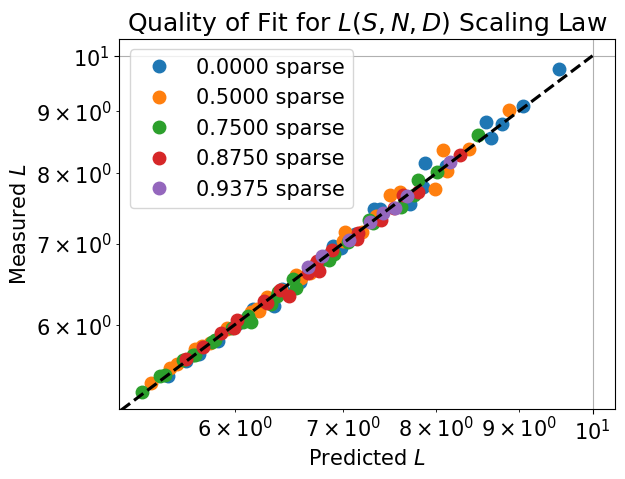

In [ ]:
pred = law(x, params)
for sparsity in [0, 0.5, 0.75, 0.875, 1 - 1 / 16]:
  tmp = x[0] == sparsity
  plt.plot(pred[tmp], y[tmp], 'o', label='%.4f sparse' % sparsity)
plt.plot([0, 10], [0, 10], '--', color='black')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted $L$')
plt.ylabel('Measured $L$')
plt.legend()
plt.title('Quality of Fit for $L(S, N, D)$ Scaling Law')

plt.show()

# Read T5 data

In [ ]:
data = pd.read_csv('t5-data.csv')

PARAM_COUNT = 24 * (12 * 768 ** 2)
S = data['sparsity']
N = PARAM_COUNT * data['scale'] * (1 - data['sparsity'])
N /= 10 ** 6
D = data['steps']
D /= 10 ** 5
L = data['val-loss']

x = np.stack((S, N, D))
y = np.array(L)

# Fit Scaling Coefficients

In [ ]:
def huber(f, x, y, delta, log):
  def res(params):
    if log:
      res = np.abs(np.log(f(x, params)) - np.log(y))
    else:
      res = np.abs(f(x, params) - y)
    outlier = res > delta
    loss = np.sum(delta * (res[outlier] - .5 * delta))
    loss += np.sum(.5 * res[~outlier] ** 2)
    return loss / y.size
  return res

def law(x, params):
  S, N, D = x[0], x[1], x[2]
  a, b, c, d, e, f, g = params
  sparse = a * (1 / (1 - S)) ** -b + c
  return sparse * N ** -d + e * D ** -f + g

# Note that we follow the Chinchilla loss function here
loss = lambda f, x, y: huber(f, x, y, 0.001, True)

np.random.seed(1)

best = None
for _ in range(25):
  res = scipy.optimize.minimize(
      loss(law, x, y), np.random.uniform(size=7)
  )
  if res['success']:
    print(res['fun'])
    if best is None or best['fun'] > res['fun']:
      best = res
      print(best['fun'])

print('coefs', best['x'])
print('loss', best['fun'])
params = best['x']

1.1802075893531197e-05
1.1802075893531197e-05
1.0710772572429004e-05
1.0710772572429004e-05
8.432218571274434e-06
8.432218571274434e-06
1.1836563934656972e-05
8.141760696367502e-06
8.141760696367502e-06
8.832666912455414e-06
9.398249676979851e-06
9.372074698966257e-06
1.3711002356153409e-05
1.1473070987648155e-05
1.2483401466934045e-05
8.985120783444787e-06
7.603605281507622e-06
7.603605281507622e-06
1.2298879572345474e-05
9.374964055248003e-06
1.0942851452608748e-05
1.2292366909438011e-05
1.264880124404507e-05
1.1421337232525214e-05
8.344172454678415e-06
1.2036149339725813e-05
1.2179634283572354e-05
1.054805497528612e-05
9.622176286679677e-06
1.1409525817375396e-05
coefs [0.56778512 0.72161276 1.52265016 0.24513173 0.63361517 0.20270772
 0.65074219]
loss 7.603605281507622e-06


# Plot Quality of Fit

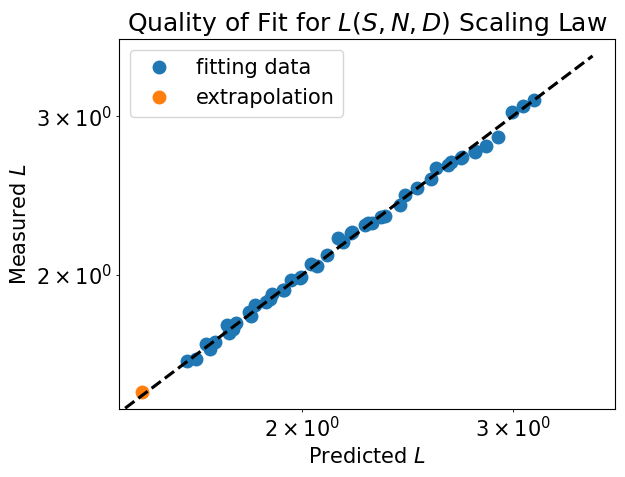

In [ ]:
pred = law(x, params)
extrapolation_x = [
    law([0.75, 48 * (12 * 1024 ** 2) / 10 ** 6, 500_000 / 10 ** 5], params),
]
extrapolation_y = 1.4827780204906797
plt.plot(pred, y, 'o', label='fitting data')
plt.plot(extrapolation_x, extrapolation_y, 'o', label='extrapolation')
plt.plot([0, 3.5], [0, 3.5], '--', color='black')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Predicted $L$')
plt.ylabel('Measured $L$')
plt.legend()
plt.title('Quality of Fit for $L(S, N, D)$ Scaling Law')

plt.show()